# Robust Linear Models

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Estimation

Load data:

In [3]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(
    hub_results.summary(
        yname="y", xname=["var_%d" % i for i in range(len(hub_results.params))]
    )
)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.791899
AIRFLOW      0.111005
WATERTEMP    0.302930
ACIDCONC     0.128650
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Apr 2025                                         
Time:                        10:02:24                                         
No. Iterations:                    19                                         


Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.089504
AIRFLOW      0.119460
WATERTEMP    0.322355
ACIDCONC     0.117963
dtype: float64


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print("Parameters: ", andrew_results.params)

Parameters:  const       -40.881796
AIRFLOW       0.792761
WATERTEMP     1.048576
ACIDCONC     -0.133609
dtype: float64


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1 - 5) ** 2))
X = sm.add_constant(X)
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [8]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 5.15575479  0.52070014 -0.01398891]
[0.42599555 0.06576796 0.00581945]
[ 4.806032    5.07332975  5.33596648  5.59394217  5.84725684  6.09591048
  6.3399031   6.57923468  6.81390523  7.04391476  7.26926326  7.48995073
  7.70597717  7.91734258  8.12404696  8.32609032  8.52347264  8.71619394
  8.90425421  9.08765345  9.26639167  9.44046885  9.60988501  9.77464013
  9.93473423 10.0901673  10.24093934 10.38705036 10.52850034 10.6652893
 10.79741723 10.92488413 11.04769    11.16583484 11.27931865 11.38814144
 11.49230319 11.59180392 11.68664362 11.77682229 11.86233994 11.94319655
 12.01939214 12.09092669 12.15780022 12.22001272 12.2775642  12.33045464
 12.37868405 12.42225244]


Estimate RLM:

In [9]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 5.09545460e+00  5.07935941e-01 -4.69344125e-03]
[0.14576464 0.02250409 0.00199126]


Draw a plot to compare OLS estimates to the robust estimates:

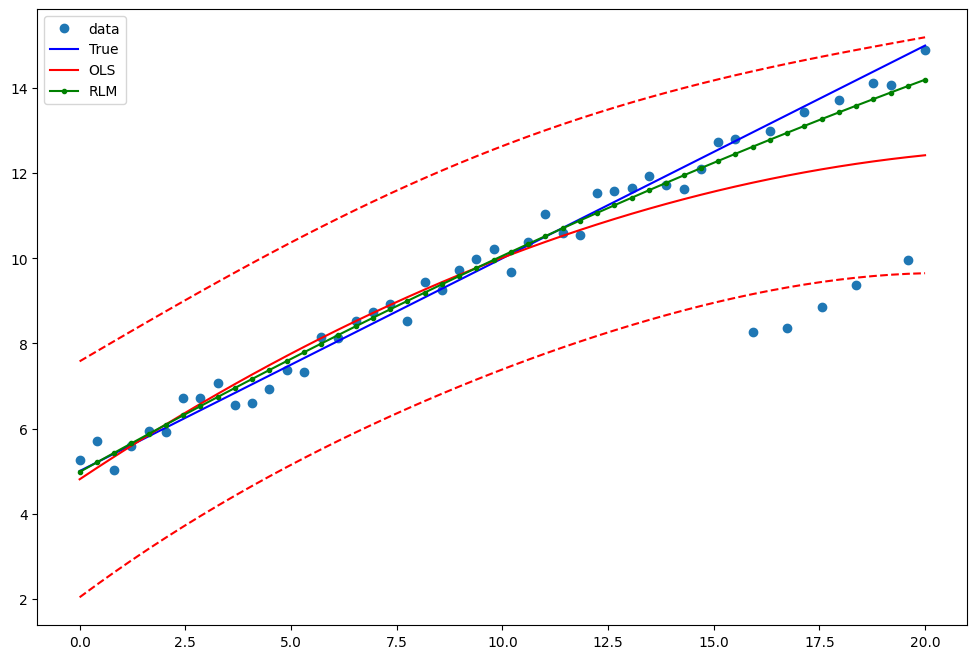

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

ax.plot(x1, res.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [11]:
X2 = X[:, [0, 1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.71959358 0.38081102]
[0.37288397 0.03212919]


Estimate RLM:

In [12]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.24911971 0.46697787]
[0.11647145 0.01003565]


Draw a plot to compare OLS estimates to the robust estimates:

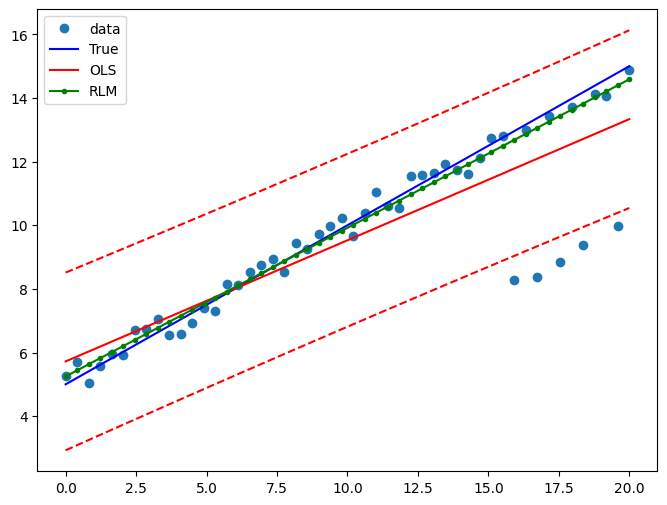

In [13]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
ax.plot(x1, res2.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm2.fittedvalues, "g.-", label="RLM")
legend = ax.legend(loc="best")